In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import glob, os, random
from google.colab import drive
drive.mount("drive", force_remount=True)

Mounted at drive


In [ ]:
DATASET_URL = "https://storage.googleapis.com/cosmic-quarter-312712/dataset/dataset-v1.zip"
PATH_DATASET = tf.keras.utils.get_file('dataset.zip', origin=DATASET_URL, extract=True)

42573824/42568536 [==============================] - 1s 0us/step


In [ ]:
BASE_PATH = '/root/.keras/datasets/'
os.listdir(BASE_PATH)

['dataset.zip', 'metal', 'cardboard', 'paper', 'plastic', 'glass']

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.1
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.1
)

train_generator = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 2259 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [ ]:
list_labels = train_generator.class_indices
keys_list_labels = list_labels.keys()
print(list_labels)

labels = '\n'.join(sorted(keys_list_labels))
with open('labels.txt', 'w') as f:
  f.write(labels)

path = 'labels.txt'
label = np.array(open(path).read().splitlines())

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4}


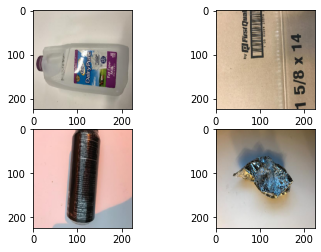

In [ ]:
img_list = glob.glob(os.path.join(BASE_PATH, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 4)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 2, i+1)
    plt.imshow(img.squeeze())

In [ ]:
IMG_SHAPE = (224,224,3)
BASE_MODEL = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
    )

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
BASE_MODEL.trainable = False

In [ ]:
model = tf.keras.Sequential([
  BASE_MODEL,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(keys_list_labels), activation='softmax')
])

In [ ]:
base_lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=base_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 128)         1474688   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 3,733,317
Trainable params: 1,475,333
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
from datetime import datetime
import pickle

def save_model(model, history, modelComment):
  modelDate = datetime.now().strftime("%Y-%m-%d_%H-%M") + "_" + modelComment
  savePath = "drive/Shareddrives/B21-CAP0331/models/" + modelDate
  !mkdir "$savePath"
  tf.saved_model.save(model, savePath)
  with open(savePath + "/history.pickle", "wb") as f:
    pickle.dump(history.history, f)
  print("Model saved to ", savePath)
  print("Model name : ", modelDate)
  drive.flush_and_unmount()
  print("Drive flushed out")
  drive.mount("drive")


In [ ]:
batch_size = 32
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    workers = 4,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    verbose = 1
    )

save_model(model, history, "model-build-v1_sebelum-fine-tune")

Epoch 1/50
70/70 [==============================] - 48s 225ms/step - loss: 1.6559 - accuracy: 0.5070 - val_loss: 0.6208 - val_accuracy: 0.7500
Epoch 2/50
70/70 [==============================] - 16s 220ms/step - loss: 0.6347 - accuracy: 0.7706 - val_loss: 0.7791 - val_accuracy: 0.7143
Epoch 3/50
70/70 [==============================] - 16s 220ms/step - loss: 0.6001 - accuracy: 0.7705 - val_loss: 0.5502 - val_accuracy: 0.8036
Epoch 4/50
70/70 [==============================] - 17s 223ms/step - loss: 0.4852 - accuracy: 0.8154 - val_loss: 0.5445 - val_accuracy: 0.7946
Epoch 5/50
70/70 [==============================] - 16s 220ms/step - loss: 0.3725 - accuracy: 0.8565 - val_loss: 0.5851 - val_accuracy: 0.7946
Epoch 6/50
70/70 [==============================] - 16s 218ms/step - loss: 0.4094 - accuracy: 0.8340 - val_loss: 0.5261 - val_accuracy: 0.8304
Epoch 7/50
70/70 [==============================] - 16s 218ms/step - loss: 0.3418 - accuracy: 0.8704 - val_loss: 0.7684 - val_accuracy: 0.7679

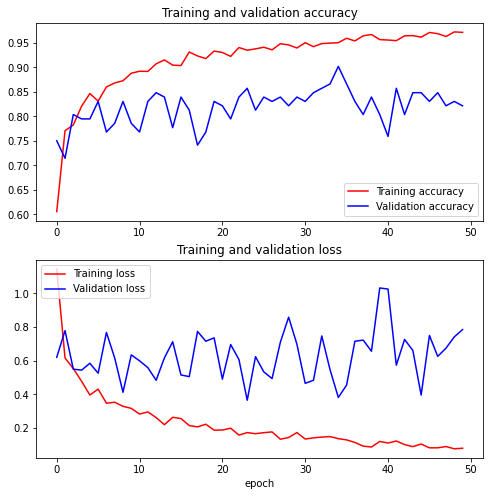

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')

plt.xlabel('epoch')

plt.show()

## FINE-TUNING

In [ ]:
BASE_MODEL.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(BASE_MODEL.layers))

fine_tune_at = 100

for layer in BASE_MODEL.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(base_lr/10), # 1e-5
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 128)         1474688   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 3,733,317
Trainable params: 3,336,773
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

58

In [ ]:
# fine_tune_epochs = epochs
# total_epochs =  epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    workers=4,
    validation_data = validation_generator,
    validation_steps = validation_steps
    )

save_model(model, history_fine, "model-build-v1_setelah-fine-tune")

Epoch 1/50
70/70 [==============================] - 23s 248ms/step - loss: 2.3622 - accuracy: 0.6356 - val_loss: 0.7448 - val_accuracy: 0.8125
Epoch 2/50
70/70 [==============================] - 16s 227ms/step - loss: 1.0445 - accuracy: 0.7740 - val_loss: 0.8959 - val_accuracy: 0.7946
Epoch 3/50
70/70 [==============================] - 16s 223ms/step - loss: 0.8393 - accuracy: 0.7952 - val_loss: 0.6677 - val_accuracy: 0.8125
Epoch 4/50
70/70 [==============================] - 17s 228ms/step - loss: 0.6244 - accuracy: 0.8361 - val_loss: 0.7032 - val_accuracy: 0.8214
Epoch 5/50
70/70 [==============================] - 17s 222ms/step - loss: 0.6235 - accuracy: 0.8129 - val_loss: 0.7498 - val_accuracy: 0.8304
Epoch 6/50
70/70 [==============================] - 17s 231ms/step - loss: 0.5057 - accuracy: 0.8467 - val_loss: 0.6758 - val_accuracy: 0.8393
Epoch 7/50
70/70 [==============================] - 17s 222ms/step - loss: 0.4954 - accuracy: 0.8400 - val_loss: 0.7105 - val_accuracy: 0.8036

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

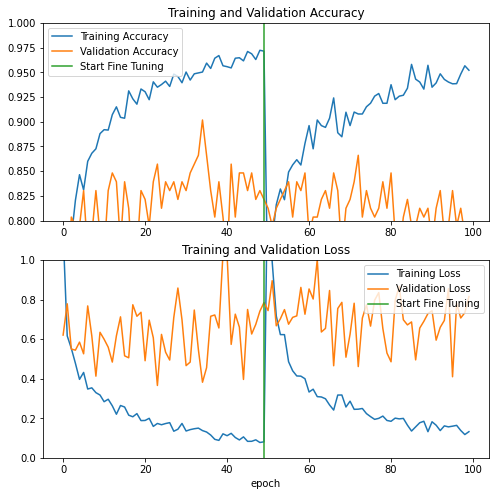

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1, epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1, epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

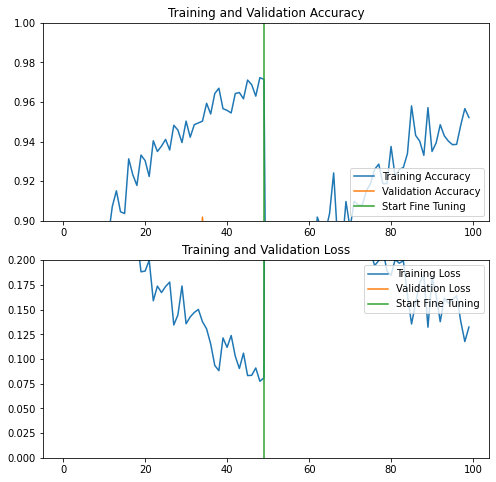

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[5.9162779e-12 9.8358058e-08 2.4342738e-11 6.4134115e-10 9.9999988e-01]]
plastic


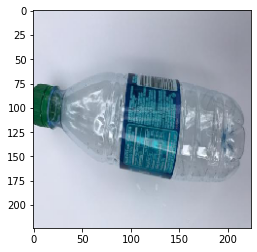

In [ ]:
img_path = BASE_PATH + '/plastic/plastic-9.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
img = img / 255
p=model.predict(img[np.newaxis, ...])
print(p)
predicted_class = label[np.argmax(p[0], axis=-1)]
print(predicted_class)